In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import scipy.io
import os
import sys
import pandas as pd
from PIL import Image

import scipy.io

from defects import *

In [ ]:
pt = r"D:\work\nematics\nematics\nematics\Ken\IO\raw_images\hbec\*tif"

img_lst = glob.glob(pt)
print(img_lst)

In [5]:
# image_list = glob.glob(r"D:\work\nematics\nematics\nematics\_bacteria\hbec_images\raw\test_flow\*tif")
image_list = glob.glob(r"D:\work\nematics\nematics\nematics\Ken\IO\raw_images\hbec\*tif")

from natsort import natsorted
image_list = natsorted(image_list, key=lambda y: y.lower())



In [ ]:
print(type(image_list[0]))

In [6]:
PLOT  = True
SAVE = False

x, y = 0, 0
win1, win2 = 600, 600
window_size = 40

for img_idx,im in enumerate(image_list):
    
    img = plt.imread(im)
    # img = img[-np.min(img.shape):,-np.min(img.shape):]


    ori, coh, E = orientation_analysis(img, 15)
    k = compute_topological_charges(ori, int_area='cell', origin='upper')
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    compute_defect_orientations(ori, defects)
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    #### PLOT the image 
    if PLOT:
        
        pix_x = img.shape[1]
        pix_y = img.shape[0]

        x = np.arange(0,pix_x)
        y = np.arange(0,pix_y)
        xx,yy = np.meshgrid(x,y)
        fig, ax  = plt.subplots(figsize=(16,16))
        
        
        s = 15 
        ax.imshow(img, cmap='gray')
        # ax.quiver(xx[::s,::s], yy[::s,::s])
        ax.quiver(xx[::s,::s], yy[::s,::s], 
            np.cos(ori)[::s,::s], np.sin(ori)[::s,::s], 
            headaxislength=0, headwidth=0, headlength=0, 
            color='lawngreen', scale=60, pivot='mid', alpha=.5)

        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=10,label=r'+1/2 defect')
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=50)

        for i in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(i+1)]), np.sin(minushalf['ang'+str(i+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=50)


    if img_idx>2:
        break




NameError: name 'xx' is not defined

In [ ]:
PLOT  = True
SAVE = False

x, y = 0, 0
win1, win2 = 600, 600

for (i,im1), im2 in zip(enumerate(image_list[:-1]),image_list[1:]):

    img1 = cv2.imread(im1)[:,:,0]
    img2 = cv2.imread(im2)[:,:,0]

    # fig, axs = plt.subplots(2,1)
    # axs = axs.flatten()
    # axs[0].imshow(img1, cmap="gray")
    # axs[1].imshow(img2, cmap="gray")


    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=61, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    if PLOT:
        fig = plt.figure(figsize=(15,10))
        step = 15
        plt.imshow(img1, cmap="gray")
        # x, y = np.arange(0, flow.shape[1], step), np.arange(flow.shape[0]-step, -1, -step)
        x = np.arange(0, flow.shape[1], step, dtype=np.int32)
        y = np.arange(0, flow.shape[0], step, dtype=np.int32)
        plt.quiver(x,y, 
                flow[::step, ::step, 0], -flow[::step, ::step, 1], color="red")
        # plt.tight_layout()
        plt.show()
        save_path = os.path.join(os.path.dirname(image_list[i]),'flow_%d.png' % i)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path)
        plt.cla()
    

    
    if SAVE:
        save_path = os.path.join(
            os.path.dirname(image_list[i]), 
            'OptFlow', 
            os.path.splitext(os.path.basename(image_list[i]))[0] + '.mat'
            )
        # break
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        scipy.io.savemat(save_path, dict(u=flow[:,:,0], v=flow[:,:,1]))
        # "C:\Users\USER\Downloads\B-sub-sur-minus-in-supernatant-40X-100fps\OptFlow\test.mat"


    # break



### test class workflow on 5 images

In [1]:
path =r"D:\work\nematics\nematics\nematics\Ken\IO\raw_images\test"
from workflow import *

WF = image_series(path,save_flow = True)
# PH,MH = WF.detect_minus_plus()

In [ ]:

image_list = glob.glob(r"D:\work\nematics\nematics\nematics\Ken\IO\raw_images\hbec\*tif")

image_list = natsorted(image_list, key=lambda y: y.lower())
image_list = image_list[::10]

save_path = os.path.normpath(image_list[0] 
    + os.sep + os.pardir
    + os.sep + os.pardir) + '\\velocity\\' #go back two dis and go to velocity


for (i,im1), im2 in zip(enumerate(image_list[:-1]),image_list[1:]):

    methods = ['cv2.TM_CCOEFF']
    # pad = 200

    img1 = cv2.imread(im1)[:,:,0]
    img2 = cv2.imread(im2)[:,:,0]
    
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=61, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    
    
    name = 'velocity_from_' + image_list[i].split('\\')[-1].split('.')[0] + 'mat' #

    scipy.io.savemat(save_path+name, dict(u=flow[:,:,0], v=flow[:,:,1]))
    # im = Image.fromarray(padded)
    # im.save()

    
    if i > 2: 
        break

In [2]:
bigarr = WF.get_flow()

### run the velocity on all images in hbek

In [3]:
path = r"D:\work\nematics\nematics\nematics\Ken\IO\raw_images\hbec"
from workflow import *

WF = image_series(path, save_flow= True)
WF.get_flow()

array([[[[-1.52129054,  2.81112671],
         [-1.5262723 ,  2.78933191],
         [-1.52392256,  2.75258303],
         ...,
         [-4.44611025, -2.26433063],
         [-4.43628883, -2.27905607],
         [-4.42350435, -2.29885387]],

        [[-1.51156509,  2.78405905],
         [-1.51693332,  2.76504326],
         [-1.51485121,  2.73073196],
         ...,
         [-4.44432545, -2.28160024],
         [-4.43368244, -2.29513407],
         [-4.4205761 , -2.3132093 ]],

        [[-1.50256097,  2.76087356],
         [-1.50824797,  2.7439239 ],
         [-1.50635993,  2.71146727],
         ...,
         [-4.44202185, -2.30841088],
         [-4.43131018, -2.32231164],
         [-4.41798544, -2.33858109]],

        ...,

        [[ 0.748025  , -1.15709507],
         [ 0.7543816 , -1.07166576],
         [ 0.75118059, -0.98489088],
         ...,
         [ 0.14203179, -0.30388096],
         [ 0.13627288, -0.29478443],
         [ 0.13081902, -0.28654373]],

        [[ 0.70221305, -1.14178407

## crop and tilt

In [8]:
import matplotlib.pyplot as plt
from workflow import *
import cv2
from natsort import natsorted
#load

# images in path need to have a name sorted in lexicografical 
# order according to the time they where taken
img_path = r"D:\work\nematics\nematics\nematics\Ken\IO\raw_images\test"
img_ser = image_series(img_path)

#change to natsort
#get DataFrame
df_plus, df_minus= img_ser.detect_minus_plus()
flow = img_ser.get_flow()
defect_df = pd.concat([df_plus, df_minus])

#replace values of from image with 
image_names = natsorted(defect_df['from_img'].unique(), key=lambda y: y.lower())
image_dict = {name: idx for idx,name in enumerate(image_names)}
defect_df.replace({'from_img' : image_dict})





(60, charge                     0.5
x                        650.0
y                         51.0
x_ind                      650
y_ind                       51
ang1                  3.835051
ang2                       NaN
ang3                       NaN
from_img    Trans__s2_0000.tif
Name: 60, dtype: object)
(61, charge                     0.5
x                       1846.0
y                        100.0
x_ind                     1846
y_ind                      100
ang1                 -0.052612
ang2                       NaN
ang3                       NaN
from_img    Trans__s2_0000.tif
Name: 61, dtype: object)
(62, charge                     0.5
x                        487.0
y                        135.0
x_ind                      487
y_ind                      135
ang1                  0.783019
ang2                       NaN
ang3                       NaN
from_img    Trans__s2_0000.tif
Name: 62, dtype: object)
(63, charge                     0.5
x                        312.0
y     

In [72]:

half_size = 200
sq_image_shape = 2048
for idx,row in defect_df.iterrows():

    #get window around defect 
    x,y = row['x_ind'],row['y_ind']
    x_start,x_stop = x- half_size , x + half_size
    y_start, y_stop = y - half_size, y + half_size
    if (y_stop > sq_image_shape) or (x_stop > sq_image_shape) or (x_start < 0) or (y_start < 0):
        continue

    x_range = np.arange(x_start,x_stop)
    y_range = np.arange(y_start,y_stop)
    window = np.meshgrid(x_range, y_range)
    print(idx,window)
    break
    

66 [array([[ 863,  864,  865, ..., 1260, 1261, 1262],
       [ 863,  864,  865, ..., 1260, 1261, 1262],
       [ 863,  864,  865, ..., 1260, 1261, 1262],
       ...,
       [ 863,  864,  865, ..., 1260, 1261, 1262],
       [ 863,  864,  865, ..., 1260, 1261, 1262],
       [ 863,  864,  865, ..., 1260, 1261, 1262]]), array([[ 26,  26,  26, ...,  26,  26,  26],
       [ 27,  27,  27, ...,  27,  27,  27],
       [ 28,  28,  28, ...,  28,  28,  28],
       ...,
       [423, 423, 423, ..., 423, 423, 423],
       [424, 424, 424, ..., 424, 424, 424],
       [425, 425, 425, ..., 425, 425, 425]])]


### rotate the image around its center

<function matplotlib.pyplot.show(close=None, block=None)>

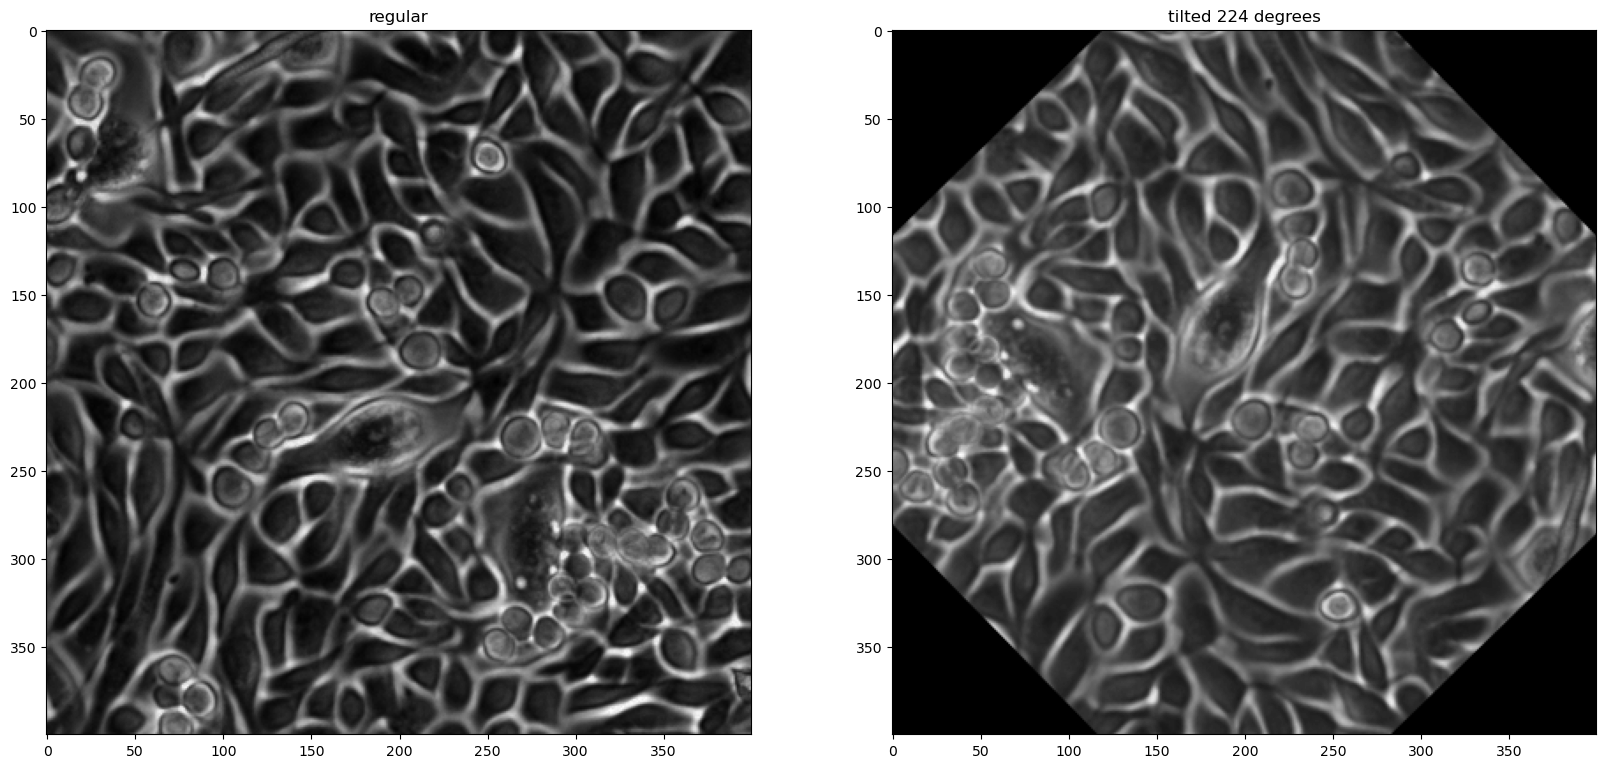

In [122]:
#get image in window 
i = 0
img_around_defect = img_ser.images[i].img[x_start:x_stop,y_start:y_stop]
img_around_defect

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_around_defect,cmap = 'gray')

#calc rotation matrix
angle = row['ang1']*(180/np.pi)
rot_mat = cv2.getRotationMatrix2D((half_size,half_size), angle, scale = 1) 
rotated = cv2.warpAffine(img_around_defect,rot_mat,(half_size*2,half_size *2))
ax[1].imshow(rotated,cmap = 'gray')

#tilt every window 
ax[0].set_title('regular')
ax[1].set_title(f'tilted {round(angle)} degrees')
fig.set_figheight(10)
fig.set_figwidth(20)
plt.show

### crop the image 

In [127]:
new_size = np.floor(half_size/np.sqrt(2))
croped = rotated[half_size-new_size : half_size + new_size, half_size - new_size: half_size + new_size]

TypeError: slice indices must be integers or None or have an __index__ method

In [107]:
img_around_defect

array([[34, 29, 27, ..., 21, 21, 23],
       [34, 32, 30, ..., 21, 21, 21],
       [39, 36, 33, ..., 21, 21, 23],
       ...,
       [26, 25, 24, ..., 46, 41, 39],
       [26, 26, 25, ..., 50, 47, 46],
       [29, 26, 24, ..., 59, 60, 59]], dtype=uint8)